# PSSM generation

In [1]:
from BioML.utilities.utils import MmseqsClustering

In [2]:
fasta_file = "../data/whole_sequence.fasta"

In [4]:
pssm_file = MmseqsClustering.easy_generate_pssm(input_file=fasta_file, 
database_file="../data/whole_sequence.fasta", generate_searchdb=True, pssm_filename="results.pssm")

start running createdb
It took 0.014882087707519531 second to run
start running search
It took 0.006601572036743164 second to run
start running generate_profile
It took 0.25417590141296387 second to run
start running convert profile to pssm
It took 0.07029223442077637 second to run


In [5]:
MmseqsClustering.split_pssm(pssm_file)

# Extract Features

In [1]:
from BioML.features.extraction import PossumFeatures, IfeatureFeatures, read_features

In [5]:
ifeatures = IfeatureFeatures("/home/ruite/Projects/enzyminer/iFeature")
possum = PossumFeatures(pssm_dir="pssm", program="/home/ruite/Projects/enzyminer/POSSUM_Toolkit")
#possum.extract(fasta_file)
ifeatures.extract(fasta_file)

iFeature features to be extracted: {'long': ['Moran', 'Geary', 'NMBroto'], 'short': ['CTriad', 'CTDD', 'SOCNumber', 'GAAC', 'CKSAAGP', 'GDPC', 'APAAC', 'CTDC', 'CTDT', 'KSCTriad', 'GTPC', 'QSOrder', 'PAAC']}
Possum features to be extracted: {'long': ['tri_gram_pssm', 'pssm_cc'], 'short': ['smoothed_pssm:5', 'tpc', 'pssm_composition', 'edp', 'dpc_pssm', 'pse_pssm:2', 'k_separated_bigrams_pssm', 'pse_pssm:1', 'd_fpssm', 'rpssm', 'eedp', 'smoothed_pssm:9', 'pse_pssm:3', 's_fpssm', 'ab_pssm', 'smoothed_pssm:7', 'pssm_ac', 'dp_pssm', 'rpm_pssm', 'aac_pssm']}
start running Ifeature programs
It took 20.16299796104431 second to run


# Optional steps

###  LLM embeddings

In [2]:
from BioML.deep import embeddings

In [5]:
embeddings.generate_embeddings(fasta_file)

/home/ruite/miniconda3/envs/bioml_pycaret/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/147 [00:00<?, ? examples/s]

### Feature selection

In [10]:
import pandas as pd
from BioML.features import methods, selection

In [7]:
ifeat = read_features("ifeature")
emb = pd.read_csv("embeddings.csv", index_col=0)

In [21]:
features = selection.DataReader("../data/esterase_labels.csv", ifeat)

In [25]:
problem="classification"

15-05-2024 18:26:53 INFO Reading the features
15-05-2024 18:26:53 INFO Starting feature selection and using the following parameters
15-05-2024 18:26:53 INFO seed: 10
15-05-2024 18:26:53 INFO filtering the features
Features [1237 1297 1390 1815 1875 1968] are constant.
invalid value encountered in divide


classification filter: mutual_info
classification filter: Fscore
classification filter: chi2
classification filter: FechnerCorr
classification filter: KendallCorr
generating a feature set of 50 dimensions


{'mutual_info_50':           hydrophobicity_CASG920101.1.residue50_CTDD  Schneider.Xr.A_QSOrder  \
 #                                                                              
 EH1(72)                                    46.666667                0.136929   
 EH2(71)                                    50.146628                0.139970   
 EH3(69)                                    50.000000                0.118054   
 CalB(68)                                   49.532710                0.158505   
 EH4(67)                                    50.000000                0.133523   
 ...                                              ...                     ...   
 EH141(1)                                   51.633987                0.100873   
 EH142(1)                                   53.802817                0.099638   
 EH143(1)                                   51.745068                0.090902   
 EH144(1)                                   48.148148                0.059750   
 EH145(1) 

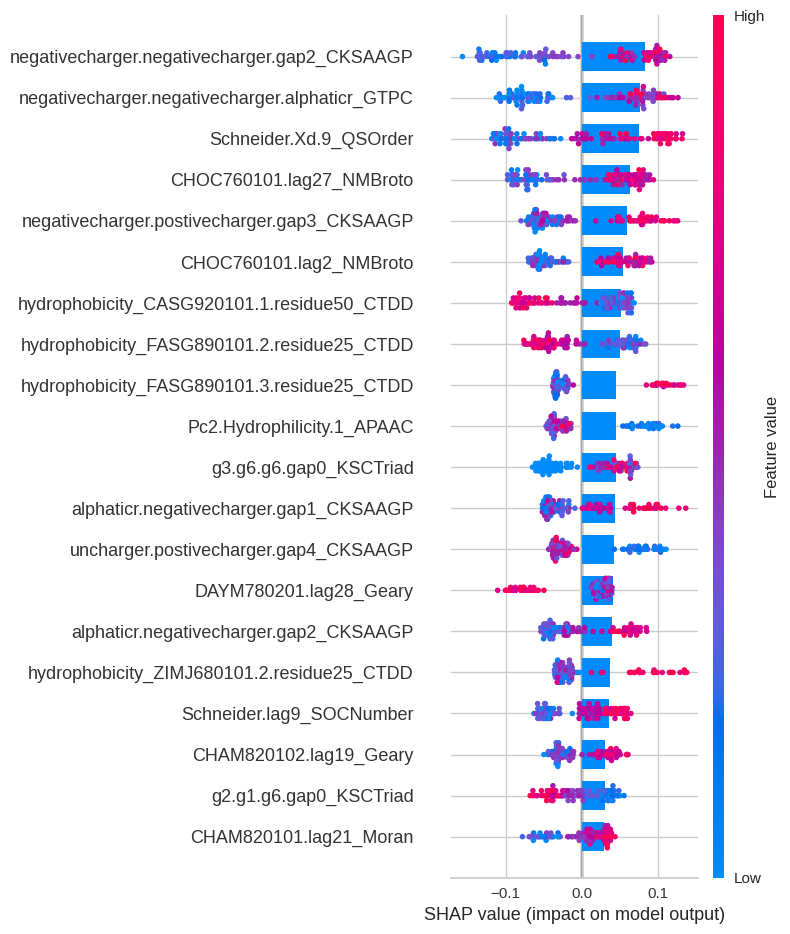

In [29]:
feature_range = selection.get_range_features(features.features)
filters = selection.FeatureSelection("filtered_features.xlsx", num_thread=1, seed=10)
# select features
if problem == "classification":
    select = selection.FeatureClassification(filters.seed, scaler="robust", test_size=0.2)
elif problem == "regression":
    select = selection.FeatureRegression(filters.seed, scaler="robust", test_size=0.2)

select.construct_features(features.features, features.label, filters, [50])

### Outlier detection

In [1]:
from BioML.utilities.outlier import OutlierDetection

In [2]:
detection = OutlierDetection("filtered_features.xlsx", num_thread=4)
detection.run()

using chi2_50 for outlier calculations


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    2.0s remaining:    8.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    2.5s finished


using random_50 for outlier calculations


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


using rfe_50 for outlier calculations


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


using FechnerCorr_50 for outlier calculations


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


using xgbtree_50 for outlier calculations


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


using Fscore_50 for outlier calculations


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


using mutual_info_50 for outlier calculations


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


using KendallCorr_50 for outlier calculations
saving the outlier file


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


#
EH46(23)     51
EH144(1)     45
EH49(23)     44
EH100(11)    39
EH116(7)     26
             ..
EH69(18)      0
EH35(29)      0
EH9(61)       0
EH23(34)      0
EH140(1)      0
Length: 147, dtype: int64

## Custom splitting based on 30% sequence identity

In [15]:
from BioML.utilities.utils import MmseqsClustering
from BioML.utilities.split_methods import ClusterSpliter
from BioML.models.base import DataParser
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path

Generate different clusters of sequences based on an identity threshold of 30%

In [11]:
cluster = MmseqsClustering.easy_cluster(fasta_file, cluster_at_sequence_identity=0.3)

start running cluster
It took 0.004034757614135742 second to run
start running create tsv
It took 0.02975177764892578 second to run


Now split based on this sequence identity cluster, the clusters can use string or numbers as lon g as it has the same index as the names of the sequences

In [20]:
split = ClusterSpliter("cluster.tsv", 5, random_state=100, stratified=True)
data = DataParser("filtered_features.xlsx", "../data/esterase_labels.csv", sheets="chi2_50")
X_train, X_test, _, _ = split.train_test_split(data.features, data.features[data.label])

/home/ruite/Projects/BioML/BioML/models/base.py:100: UserWarning: The excel file contains more than one sheet, only the sheet chi2_50 will be used
  warnings.warn(f"The excel file contains more than one sheet, only the sheet {sheets} will be used")


## Classification

In [25]:
from BioML.models.classification import Classifier
from BioML.models.base import PycaretInterface, Trainer
from collections import defaultdict
from functools import partial
import pandas as pd
import numpy as np

In [23]:
plot = ("learning", "confusion_matrix", "class_report")

In [26]:
experiment = PycaretInterface("classification", 250, budget_time=20, best_model=3, 
                                  output_path="classification_training", optimize="MCC")
classifier = Classifier(test_size=0.2, optimize="MCC", drop=())
training = Trainer(experiment, classifier, 5, 50)

15-05-2024 22:04:11 INFO ------------------------------------------------------------------------------
15-05-2024 22:04:11 INFO PycaretInterface parameters
15-05-2024 22:04:11 INFO Seed: 250
15-05-2024 22:04:11 INFO Budget time: 20
15-05-2024 22:04:11 INFO The number of models to select: 3
15-05-2024 22:04:11 INFO Output path: classification_training
15-05-2024 22:04:11 INFO ----------------Trainer inputs-------------------------
15-05-2024 22:04:11 INFO Number of kfolds: 5
15-05-2024 22:04:11 INFO Number of retuning iterations: 50


In [27]:
results, models = training.generate_training_results(X_train, data.label, tune=True, test_data=X_test, fold_strategy=split)

2024/05/15 22:06:39 INFO mlflow.tracking.fluent: Experiment with name 'Classification' does not exist. Creating a new experiment.
15-05-2024 22:06:39 INFO --------------------------------------------------------
15-05-2024 22:06:39 INFO Training classification models
15-05-2024 22:06:39 INFO The models used ['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'gbc', 'lda', 'et', 'xgboost', 'lightgbm', 'catboost', 'dummy']
15-05-2024 22:06:39 INFO Time budget is 20 minutes
/home/ruite/miniconda3/envs/bioml_pycaret/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
15-05-2024 22:06:43 INFO Model ada trained in 0.062 minutes
15-05-2024 22:06:45 INFO Model svm trained in 0.041 minutes
15-05-2024 22:06:46 INFO Model ridge trained in 0.016 minutes
15-05-2024 22:06:48 INFO Model xgboost trained in 0.02 minutes
15-05-2024 22:06:49 INFO Model nb traine

##### Acces the ClaasificationExperiment from Pycaret and play with the models if you want

In [31]:
test_set_predictions = training.generate_holdout_prediction(models)

In [32]:
training_output = "classification_results"
l = []
for tune_status, result_dict in results.items():
    for key, value in result_dict.items():
        classification.write_results(f"{training_output}/{tune_status}", *value, sheet_name=key)
    classification.write_results(f"{training_output}/{tune_status}", test_set_predictions[tune_status] , sheet_name=f"test_results")

## Save Model from pre-trained

In [45]:
models["tuned"]["holdout"]

{'qda': QuadraticDiscriminantAnalysis(priors=None, reg_param=0.8258792813861613,
                               store_covariance=False, tol=0.0001),
 'knn': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                      metric_params=None, n_jobs=-1, n_neighbors=24, p=2,
                      weights='uniform'),
 'nb': GaussianNB(priors=None, var_smoothing=0.7918521648729947)}

In [33]:
from BioML.models import save_model

In [18]:
generate = save_model.GenerateModel(training)
for status, model in models.items():
    for key, value in model.items():
        if key == "holdout":
            for num, mod in enumerate(value.values()):
                if num > training.experiment.best_model - 1 : break
                final_model = generate.finalize_model(value, num)
                generate.save_model(final_model, f"model_output/{key}_{status}")
        else:
            final_model = generate.finalize_model(value)
            generate.save_model(final_model, f"model_output/{key}_{status}")

28-03-2024 12:38:51 INFO ----------Finalizing the model by training it with all the data including test set--------------


Transformation Pipeline and Model Successfully Saved


## Save Model from scratch

In [12]:
from BioML.models import save_model

In [17]:
data = save_model.DataParser("../data/esterase_features.xlsx", "../data/esterase_labels.csv", sheets="ch2_20")
experiment = save_model.PycaretInterface("classification", 200, budget_time=20, best_model=3, 
                                  output_path="classification_training", optimize="MCC", experiment_name="generate_model")
classifier = save_model.Classifier(test_size=0.2, optimize="MCC", selected=("qda", "rbfsvm", "ridge"))
training = save_model.Trainer(experiment, classifier, 5, 30)


27-03-2024 14:28:52 INFO ------------------------------------------------------------------------------
27-03-2024 14:28:52 INFO PycaretInterface parameters
27-03-2024 14:28:52 INFO Seed: 200
27-03-2024 14:28:52 INFO Budget time: 20
27-03-2024 14:28:52 INFO The number of models to select: 3
27-03-2024 14:28:52 INFO Output path: classification_training
27-03-2024 14:28:52 INFO ----------------Trainer inputs-------------------------
27-03-2024 14:28:52 INFO Number of kfolds: 5
27-03-2024 14:28:52 INFO Number of iterations: 30


In [19]:
sorted_results, sorted_models, top_params = training.run_training(data.features, data.label)

2024/03/27 14:28:55 INFO mlflow.tracking.fluent: Experiment with name 'generate_model' does not exist. Creating a new experiment.
27-03-2024 14:28:56 INFO --------------------------------------------------------
27-03-2024 14:28:56 INFO Training classification models
27-03-2024 14:28:56 INFO The models used ['lr']
27-03-2024 14:28:56 INFO Time budget is 20 minutes
27-03-2024 14:29:01 INFO Model lr trained in 0.092 minutes
27-03-2024 14:29:01 INFO Training over: Total runtime 0.092 minutes


Model lr trained in 0.092 minutes


In [20]:
generate = save_model.GenerateModel(training)
models =  generate.train_by_strategy(sorted_models, "majority")
final_model = generate.finalize_model(models)
generate.save_model(final_model, "model_output/logistic")

27-03-2024 14:29:02 INFO ----------Finalizing the model by training it with all the data including test set--------------


Transformation Pipeline and Model Successfully Saved


## Prediction

In [34]:
from BioML.models import predict
import pandas as pd
import numpy as np
from scipy.spatial import distance

In [23]:
training_features = "filtered_features.xlsx"
label = "../data/esterase_labels.csv"
outlier_train=()
outlier_test=()
sheet_name="chi2_50"
problem="classification"
model_path="model_output/majority"
scaler="robust"

#### generate the predictions

In [40]:
feature = predict.DataParser(training_features, label, outliers=outlier_train, sheets=sheet_name)
test_features = feature.remove_outliers(feature.read_features(test_features, "chi2_50"), outlier_test)
predictions = predict.predict(test_features, model_path, problem)


#### Optional if you want to filter predictions based if that test sample is within the applicability domain

Applicability domain compares eucleadian distance between the features from the training and features from the test.   
If the distance is far from a set threshold then that prediction is discarded since it deviates from the samples the model have seen during training

In [41]:
transformed, scaler_dict, test_x = predict.scale(scaler, feature.drop(), test_features)
filtered_pred = predict.domain_filter(predictions, transformed, test_x, 5) # it returns the predictions appended to the features

In [44]:
filtered_pred.shape, predictions.shape

((120, 20), (147, 19))

In [ ]:
 # if you don't apply the domain filter, you can just use the predictions but you have to change the index to sample_0, sample_1, etc
predictions.index = [f"sample_{x}" for x, _ in enumerate(predictions.index)]
col_name = ["prediction_score", "prediction_label", "AD_number"]
predictions = predictions.loc[:, predictions.columns.str.contains("|".join(col_name))] # only keep the columns with the prediction scores

### Separate the fasta file into positive or negative

In [34]:
fasta = "../data/whole_sequence.fasta"
res_dir = "prediction_results_domain"

In [35]:
extractor = predict.FastaExtractor(fasta, res_dir)
positive, negative = extractor.separate_negative_positive(predictions)


In [36]:
extractor.extract(positive, negative, positive_fasta=f"positive.fasta", negative_fasta=f"negative.fasta")